In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy
import sklearn
import sklearn.datasets
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

sns.set_style('darkgrid')
np.random.seed(42)
# Print versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('Numpy: {}'.format(np.__version__))
print('Tensorflow: {}'.format(tf.__version__))
print('Tensorflow Probability: {}'.format(tfp.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.6.6
Numpy: 1.14.5
Tensorflow: 1.11.0
Tensorflow Probability: 0.4.0
sklearn: 0.19.2
matplotlib: 2.2.3
seaborn: 0.9.0


/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


- https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcessRegressionModel
- https://www.tensorflow.org/probability/api_docs/python/tfp/positive_semidefinite_kernels
- https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/positive_semidefinite_kernels

In [3]:
EPS = 1e-6

In [4]:
# # Define the true function that we want to regress on
# f_sin = lambda x: (np.sin(x)).flatten()

# n1 = 20  # Number of points to condition on (training points)
# n2 = 100
# domain = (-10, 10)

# # Sample some points (X1, y1) on the function
# X1 = np.random.uniform(*domain, size=(n1,1))
# y1 = f_sin(X1)
# noise = 0.0 # The variance of the noise
# # Add noise to the samples we sampled previously
# y1_noisy = np.expand_dims(
#     y1 + noise * np.random.randn(n1), 1)

In [5]:
# # Predict points at uniform spacing to capture function
# X2 = np.linspace(*domain, n2).reshape(-1,1)

# # Plot the postior distribution and some samples
# fig, ax1 = plt.subplots(nrows=1, ncols=1)
# # Plot the distribution of the function (mean, covariance)
# ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
# ax1.plot(X1, y1_noisy, 'ko', linewidth=2, label='$(x_1, y_1)$')
# ax1.set_xlabel('$x$', fontsize=15)
# ax1.set_ylabel('$y$', fontsize=15)
# ax1.axis([*domain, -2, 2])
# plt.show()
# #

observation_index_points:  (50, 1)
observations:  (50,)
index_points:  (100, 1)
kernel:  <class 'tensorflow_probability.python.positive_semidefinite_kernels.matern.MaternFiveHalves'>
gprm:  <class 'tensorflow_probability.python.distributions.gaussian_process_regression_model.GaussianProcessRegressionModel'>
samples:  (10, 100)


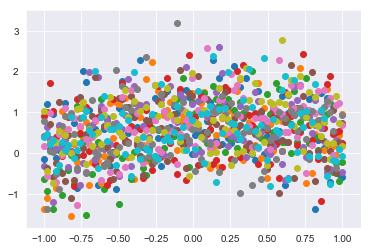

In [6]:
# Draw joint samples from the posterior predictive distribution in a GP

# Generate noisy observations from a known function at some random points.
observation_noise_variance = .5
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)
observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = (
    f(observation_index_points) + 
    np.random.normal(0., np.sqrt(observation_noise_variance)))
print('observation_index_points: ', observation_index_points.shape)
print('observations: ', observations.shape)

index_points = np.linspace(-1., 1., 100)[..., np.newaxis]
print('index_points: ', index_points.shape)

kernel = psd_kernels.MaternFiveHalves()
print('kernel: ', type(kernel))

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)
print('gprm: ', type(gprm))

samples = gprm.sample(10)
print('samples: ', samples.shape)
# ==> 10 independently drawn, joint samples at `index_points`.

with tf.Session() as sess:
    samples_eval = sess.run(samples)
    for i in range(samples_eval.shape[0]):
        plt.scatter(index_points, samples_eval[i,:])
plt.show()

Step 0: NLL = 829.860263045174
Step 100: NLL = -25.74120480806483
Step 200: NLL = -34.84849272174131
Step 300: NLL = -41.073817609081814
Step 400: NLL = -42.672032387765256
Step 500: NLL = -42.746251240251084
Step 600: NLL = -42.74658322157741
Step 700: NLL = -42.746583240590056
Step 800: NLL = -42.74658324059037
Step 900: NLL = -42.74658324059028
Final NLL = -42.74658324059007


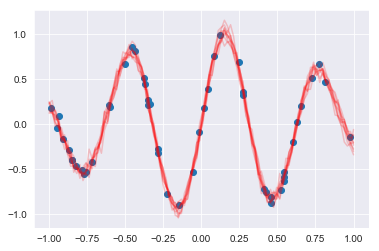

In [7]:
# Optimize model parameters via maximum marginal likelihood

# Suppose we have some data from a known function. Note the index points in
# general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one
# here).
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)

observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = f(observation_index_points) + np.random.normal(0., .05, 50)

# Define a kernel with trainable parameters. Note we transform the trainable
# variables to apply a positivity constraint.
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(0)), name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

observation_noise_variance = tf.exp(
    tf.Variable(np.float64(-5)), name='observation_noise_variance')

# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)
neg_log_likelihood = -gp.log_prob(observations)

optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(neg_log_likelihood)

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the same parameters, which we'll optimize below).
index_points = np.linspace(-1., 1., 100)[..., np.newaxis]
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10)
# ==> 10 independently drawn, joint samples at `index_points`.

# Now execute the above ops in a Session, first training the model
# parameters, then drawing and plotting posterior samples.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        _, neg_log_likelihood_ = sess.run([optimize, neg_log_likelihood])
        if i % 100 == 0:
            print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

    print("Final NLL = {}".format(neg_log_likelihood_))
    samples_ = sess.run(samples)

    plt.scatter(np.squeeze(observation_index_points), observations)
    plt.plot(np.stack([index_points[:, 0]]*10).T, samples_.T, c='r', alpha=.2)
plt.show()

observation_index_points:  (25, 1)
observations:  (25,)
amplitudes:  <dtype: 'float64'> (200,)
length_scales:  <dtype: 'float64'> (200,)
observation_noise_variances:  <dtype: 'float64'> (200,)
kernel_results:  <class 'tensorflow_probability.python.mcmc.transformed_kernel.TransformedTransitionKernelResults'>
index_points:  (200, 1)
gprm:  <class 'tensorflow_probability.python.distributions.gaussian_process_regression_model.GaussianProcessRegressionModel'>
samples:  (200, 200)
kernel_results_:  <class 'tensorflow_probability.python.mcmc.transformed_kernel.TransformedTransitionKernelResults'>
samples_:  (200, 200)
Acceptance rate: 0.675


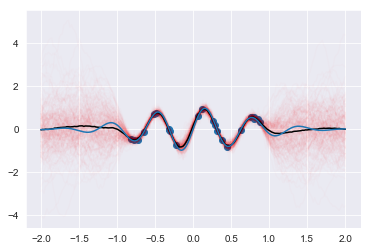

In [8]:
# Marginalization of model hyperparameters

f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)
observation_index_points = np.random.uniform(-1., 1., 25)[..., np.newaxis]
observations = np.random.normal(f(observation_index_points), .05)
print('observation_index_points: ', observation_index_points.shape)
print('observations: ',observations.shape)

def joint_log_prob(
    index_points, observations, amplitude, length_scale, noise_variance):
    # Hyperparameter Distributions.
    rv_amplitude = tfd.LogNormal(np.float64(0.), np.float64(1))
    rv_length_scale = tfd.LogNormal(np.float64(0.), np.float64(1))
    rv_noise_variance = tfd.LogNormal(np.float64(0.), np.float64(1))
    gp = tfd.GaussianProcess(
        kernel=psd_kernels.ExponentiatedQuadratic(
            amplitude, length_scale),
        index_points=index_points,
        observation_noise_variance=noise_variance)
    return (
        rv_amplitude.log_prob(amplitude) +
        rv_length_scale.log_prob(length_scale) +
        rv_noise_variance.log_prob(noise_variance) +
        gp.log_prob(observations)
    )

initial_chain_states = [
    1e-1 * tf.ones([], dtype=np.float64, name='init_amplitude'),
    1e-1 * tf.ones([], dtype=np.float64, name='init_length_scale'),
    1e-1 * tf.ones([], dtype=np.float64, name='init_obs_noise_variance')
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus(),
]

def unnormalized_log_posterior(amplitude, length_scale, noise_variance):
    return joint_log_prob(
        observation_index_points, observations, amplitude, length_scale,
        noise_variance)

num_results = 200
[
    amplitudes,
    length_scales,
    observation_noise_variances
], kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=500,
    num_steps_between_results=3,
    current_state=initial_chain_states,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            step_size=[np.float64(.15)],
            num_leapfrog_steps=3),
        bijector=unconstraining_bijectors))
print('amplitudes: ', amplitudes.dtype, amplitudes.shape)
print('length_scales: ', length_scales.dtype, length_scales.shape)
print('observation_noise_variances: ', observation_noise_variances.dtype, observation_noise_variances.shape)
print('kernel_results: ', type(kernel_results))

index_points=np.linspace(-2., 2., 200)[..., np.newaxis]
print('index_points: ', index_points.shape)
# Now we can sample from the posterior predictive distribution at a new set
# of index points.
gprm = tfd.GaussianProcessRegressionModel(
    # Batch of `num_results` kernels parameterized by the MCMC samples.
    kernel=psd_kernels.ExponentiatedQuadratic(amplitudes, length_scales),
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    # We reshape this to align batch dimensions.
    observation_noise_variance=observation_noise_variances[..., np.newaxis])
print('gprm: ', type(gprm))
samples = gprm.sample()
print('samples: ', samples.shape)


with tf.Session() as sess:
    kernel_results_, samples_ = sess.run([kernel_results, samples])
    print('kernel_results_: ', type(kernel_results_))
    print('samples_: ', samples_.shape)
    print("Acceptance rate: {}".format(
        np.mean(kernel_results_.inner_results.is_accepted)))

    # Plot posterior samples and their mean, target function, and observations.
    plt.plot(
        np.stack([index_points[:, 0]]*num_results).T,
        samples_.T,
        c='r', alpha=.01)
    plt.plot(index_points[:, 0], np.mean(samples_, axis=0), c='k')
    plt.plot(index_points[:, 0], f(index_points))
    plt.scatter(observation_index_points[:, 0], observations)
plt.show()